### 0. Pré-processamento

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output as cls
from IPython.display import Markdown

In [2]:
def show_images(data, class_names, model=None, GRID=[6,5], SIZE=(24,16)):
    
    # Plot Configurations
    n_rows, n_cols = GRID
    n_images = n_cols * n_rows
    plt.figure(figsize=SIZE)
    p = 0
    i = 1
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        class_index = np.argmax(labels[id])
        image, label = tf.expand_dims(images[id], axis=0), class_names[class_index]
        
        image = tf.image.adjust_brightness(image, 0.3)
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image[0])
        
        #make Prediction
        if model is not None:
            prediction = model.predict(image)[0]
            score = np.round(max(prediction), 2)
            pred = class_names[np.argmax(prediction)]
            title = f"True : {label}\nPred : {pred}"
            if(label==pred):
                p+=1
        else:
            title = label
        
        plt.title(title)
        plt.axis('off')
        cls()
        
        i+=1
        if i>n_images:
            break
    acuracia = (p/n_images)*100
    acuracia = f"{acuracia:.2f}"
    Markdown(f'Acurácia nos predicts: {acuracia}')
    plt.show()

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Erro ao definir a alocação de memória dinâmica")

I0000 00:00:1724510647.455626  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724510647.487288  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724510647.487353  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### 1. Importação do modelo usado para TransferLearning

In [4]:
base_model = keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.01,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax",
)


I0000 00:00:1724510647.525800  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724510647.525884  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724510647.525900  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724510647.771011  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724510647.771074  533743 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
# base_model.summary()

In [6]:
base_model.treinable = True

- Define o modelo como "treinable" para não freezar as camadas, almejando uma maior acurácia.

### 2. Adicionar novas camadas e definir modelo final que será treinado

In [7]:
inputs = keras.Input(shape=(None, None, 3)) 

x = base_model(inputs, training=True)

x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, None, None,     │     3,228,864 │
│                                 │ 1024)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 3,217,226 (12.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

- Visualização do modelo final

### 3. Compila o modelo

In [9]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

### 4. Carrega as imagens de treino e validação

- Faz um simples Data Augmentation 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,  # media de cada sample para 0
    rotation_range=10,  # rotação da imagem
    zoom_range=0.1,  # zoom
    width_shift_range=0.1,  # desloca horizontalmente
    height_shift_range=0.1,  # desloca verticalmente
    horizontal_flip=True,  # espelha a imagem horizontalmente
    vertical_flip=True, #espelha a imagem verticalmente
    )



datagen_valid = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True, 
    rotation_range=10,  
    zoom_range=0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True,
    )

- Carrega propriamente os dados

In [11]:

batch_size = 32
train_it = datagen_train.flow_from_directory(
    "FastFoodClassificationV2/Train",
    color_mode="rgb",
    class_mode="categorical",
    batch_size = batch_size,
    target_size = (224, 224)
)

valid_it = datagen_valid.flow_from_directory(
    "FastFoodClassificationV2/Valid",
    color_mode="rgb",
    class_mode="categorical",
    batch_size = batch_size,
    target_size = (224, 224)
)


Found 14549 images belonging to 10 classes.
Found 3478 images belonging to 10 classes.


### 5. Visualização das imagens depois do Data Augmentation

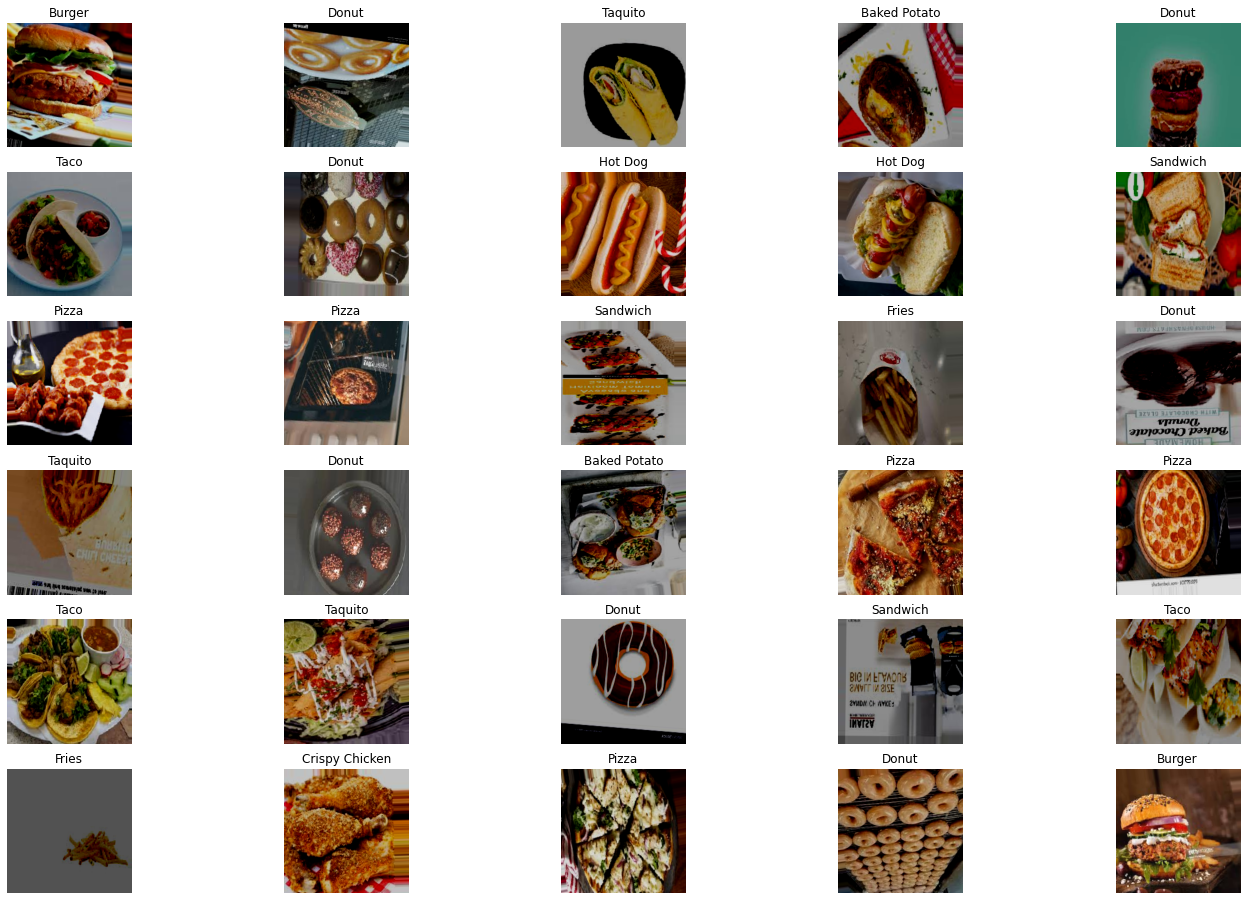

In [12]:
show_images(train_it, class_names = sorted(os.listdir('FastFoodClassificationV2/Train')))

### 6. Treinamento do modelo

In [13]:
history = model.fit(train_it,
          validation_data=valid_it,
        batch_size = batch_size,
        epochs=50)

Epoch 1/50


/home/paulo/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724510665.921281  533851 service.cc:146] XLA service 0x7f1fd411a610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724510665.921367  533851 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
E0000 00:00:1724510678.204758  533851 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724510678.446439  533851 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. T

455/455 ━━━━━━━━━━━━━━━━━━━━ 173s 325ms/step - accuracy: 0.5933 - loss: 1.4014 - val_accuracy: 0.4948 - val_loss: 3.0139
Epoch 2/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 127s 276ms/step - accuracy: 0.7722 - loss: 0.7436 - val_accuracy: 0.6860 - val_loss: 1.1793
Epoch 3/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 125s 272ms/step - accuracy: 0.8011 - loss: 0.6162 - val_accuracy: 0.6912 - val_loss: 1.3774
Epoch 4/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 135s 293ms/step - accuracy: 0.8197 - loss: 0.5639 - val_accuracy: 0.6797 - val_loss: 1.1182
Epoch 5/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 136s 294ms/step - accuracy: 0.8439 - loss: 0.4982 - val_accuracy: 0.7030 - val_loss: 1.0982
Epoch 6/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 135s 292ms/step - accuracy: 0.8492 - loss: 0.4797 - val_accuracy: 0.7392 - val_loss: 1.0363
Epoch 7/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 135s 293ms/step - accuracy: 0.8644 - loss: 0.4226 - val_accuracy: 0.7657 - val_loss: 0.9011
Epoch 8/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 134s 291ms/step - accuracy: 0.8736 - loss: 0.39

### 7. Visualização dos resultados

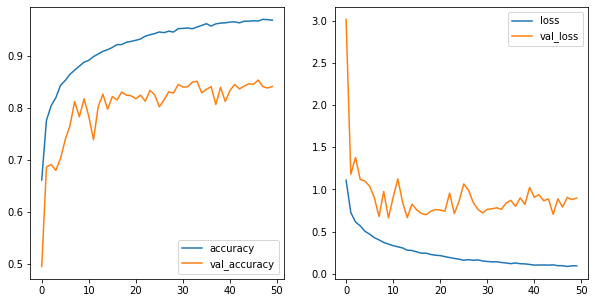

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
fig, ax = plt.subplots(1,2, figsize=(10,5))
for i, radical in enumerate(['accuracy', 'loss']):
    for prefix in ['', 'val_']:
        ax[i].plot(history.history[prefix+radical], label = prefix+radical)
    ax[i].legend()
    # ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

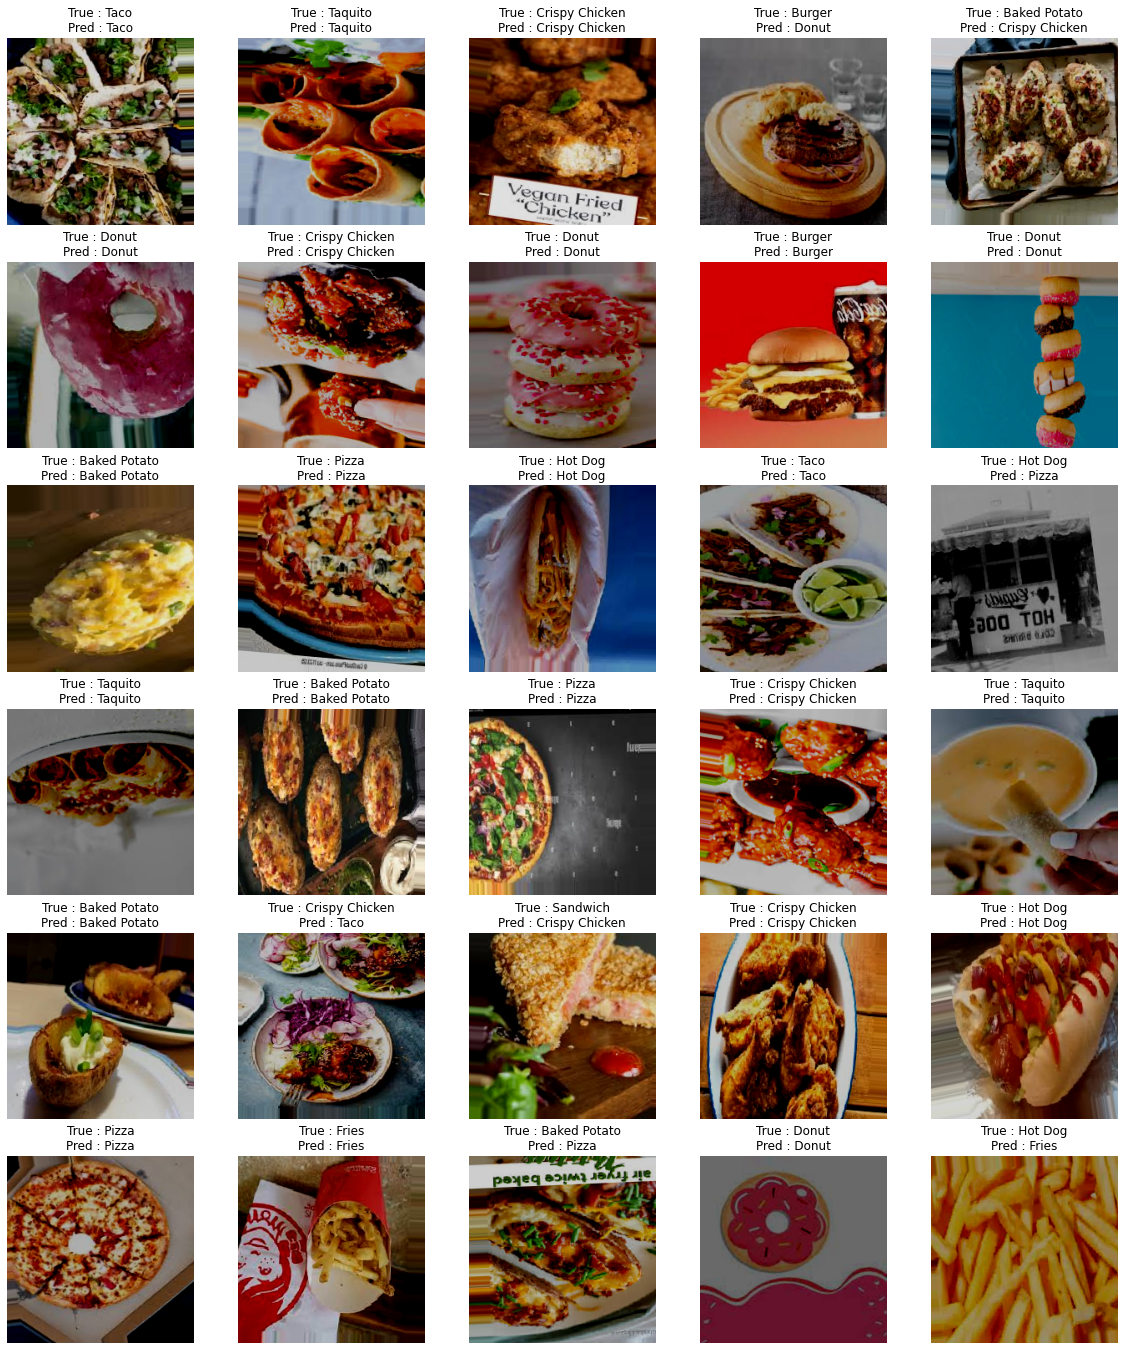

In [15]:
show_images(valid_it, model= model, class_names = sorted(os.listdir('FastFoodClassificationV2/Train')), SIZE = (20, 24))

In [16]:
model.save('mobilenet.keras')